In [87]:
import pandas as pd
import scipy as sp
import numpy as np
import json
import csv
import matplotlib.pyplot as plt

In [111]:
# Read in all imt rules, track col indices
imt_rules = pd.read_csv('../mapping/JN3604IMT_rules.tsv', sep='\t')
rule_col = {name : i for i, name in enumerate(imt_rules.loc[:, "Name"])}
n_rules = len(rule_col)

# Read in all rxn db ids, track row indices
prefs = ["mc_v21", "brenda", "kegg"]
key_prefs = ["metacyc", "brenda", "kegg"]
rxn_row = {}
i = 0
for p, pref in enumerate(prefs):
    fn = f"../mapping/{pref}_as_is.json"
    with open(fn, 'r') as f:
        db = json.load(f)

    for k in db.keys():
        rxn_row[f"{key_prefs[p]}:{k}"] = i
        i += 1

n_rxns = len(rxn_row)

# Read in mappings - format as [(rxn, rule), ]
sp_mappings = set()
for p, pref in enumerate(prefs):
    fn = f"../mapping/results/mapping_{pref}_imt_rules_enforce_cof.csv"
    with open(fn, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if len(row) > 1:
                rxn = f"{key_prefs[p]}:{row[0]}"
                rules = row[1:]
                for rule in rules:
                    sp_mappings.add((rxn, rule))
jn_mappings = []
with open("../jos_rxn_data/known_rxns_w_provenance_all_info_jni.json", 'r') as f:
    jni_rxns_w_provenance = json.load(f)

for rhash, rxn_entry in jni_rxns_w_provenance.items():
    for db_id, db_entry in rxn_entry.items():
        for rule in db_entry['imt_rules']:
            jn_mappings.append((db_id, rule))


# Turn matrix index, name look ups inside out
row_rxn = {v:k for k,v in rxn_row.items()}
col_rule = {v:k for k,v in rule_col.items()}

# Construct sparse arr - iterate over mappings, look up indices, add a 1
row, col, data = list(zip(*[(rxn_row[elt[0]], rule_col[elt[1]], 1) for elt in sp_mappings]))
sp_mapping_arr = sp.sparse.csr_matrix((data, (row, col)), shape=(n_rxns, n_rules))

row, col, data = list(zip(*[(rxn_row[elt[0]], rule_col[elt[1]], 1) for elt in jn_mappings]))
jn_mapping_arr = sp.sparse.csr_matrix((data, (row, col)), shape=(n_rxns, n_rules))

metacyc:RXN-7830 rule0001_13
metacyc:RXN-7830 rule0001_13


In [112]:
diff = sp_mapping_arr - jn_mapping_arr

fn = diff[diff < 0].shape[1]
fp = diff[diff > 0].shape[1]
tp_plus_tn = diff.shape[0] * diff.shape[1] - (fn + fp)
tp = sp_mapping_arr[(sp_mapping_arr == 1).multiply(jn_mapping_arr == 1)].shape[1]
tn = tp_plus_tn - tp

print(f"TPR / Recall: {tp / (tp + fn)}")
print(f"Precision: {tp / (tp + fp)}")
print(f"FPR: {fp / (fp + tn)}")

TPR / Recall: 0.9720749327701728
Precision: 0.9265625905114986
FPR: 1.5459389414114353e-05


In [113]:
print(tp, tn, fp, fn)

63981 328015646 5071 1838


In [114]:
print(fn + fp + tp + tn)
print(n_rules * n_rxns)

328086536
328086536


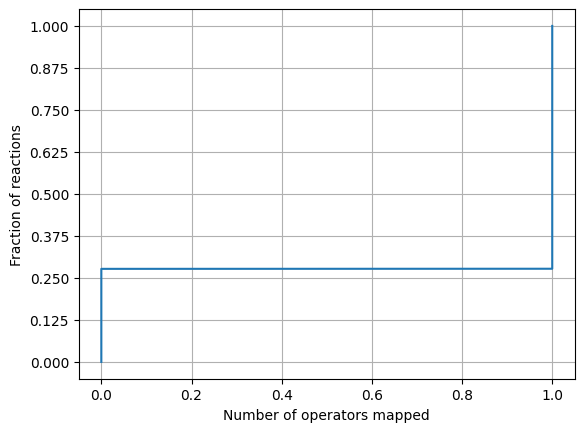

In [115]:
fig, ax = plt.subplots()
xcdf = sorted(np.array(jn_mapping_arr.sum(axis=1).reshape(-1,)).reshape(-1,))
ycdf = np.arange(1, len(xcdf) + 1) / len(xcdf)
ax.plot(xcdf, ycdf)
ax.set_xlabel("Number of operators mapped")
ax.set_ylabel("Fraction of reactions")
ax.set_yticks(np.linspace(0, 1, num=9))
ax.grid()
plt.show()


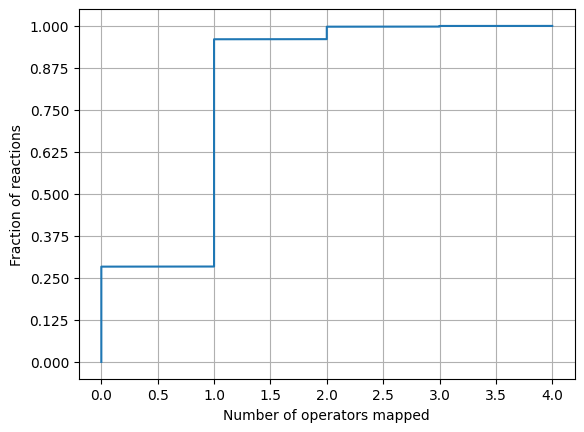

In [116]:
fig, ax = plt.subplots()
xcdf = sorted(np.array(sp_mapping_arr.sum(axis=1).reshape(-1,)).reshape(-1,))
ycdf = np.arange(1, len(xcdf) + 1) / len(xcdf)
ax.plot(xcdf, ycdf)
ax.set_xlabel("Number of operators mapped")
ax.set_ylabel("Fraction of reactions")
ax.set_yticks(np.linspace(0, 1, num=9))
ax.grid()
plt.show()


In [128]:
# Spot check rxns multiply mapped by me
i = 0

In [140]:
rxn_idxs = np.arange(n_rxns)[np.array(sp_mapping_arr.sum(axis=1).reshape(-1,)).reshape(-1,) > 1]
idx = rxn_idxs[i]
ruis = np.arange(n_rules)
rxn = row_rxn[idx]
sp_rules = [col_rule[elt] for elt in ruis[(sp_mapping_arr[idx] == 1).toarray().reshape(-1,)]]
jn_rules = [col_rule[elt] for elt in ruis[(jn_mapping_arr[idx] == 1).toarray().reshape(-1,)]]
print(f"Rxn: {rxn}")
print(f"SP Rules Mapped: {sp_rules}")
print(f"JN Rules Mapped: {jn_rules}")
i += 1

Rxn: metacyc:RXN-15088
SP Rules Mapped: ['rule0006_098', 'rule0006_108']
JN Rules Mapped: ['rule0006_098']
